In [1]:
# Auxiliaries (Importing Datafile, Checking Time)
import os 
import time

# Calculations
import numpy as np

# For Importing Data Files
import pandas as pd
import glob

# For Data Visualization
import matplotlib.pyplot as plt
from matplotlib.image import imread

import numpy as np
from PIL import Image
from IPython.display import display

import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import threshold_multiotsu
from skimage import color

# For Image Pre-Processing
import cv2

# Create dataframe

3 columns
1. Disease Classification
2. Image Name
3. Image RGB Values (RGB Converted from BGR)

In [2]:
def natural_sort_key(s):
    """Key function for natural sorting."""
    import re
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

def create_dataframe_from_folders(root_folder):
    # Initialize empty lists to store data for each column
    folder_names = []
    photo_names = []
    photos = []

    # Traverse through the root folder and its subfolders
    for folder_name in sorted(os.listdir(root_folder)):
        folder_path = os.path.join(root_folder, folder_name)

        # Check if the entry in the root folder is a directory
        if os.path.isdir(folder_path):
            for photo_name in sorted(os.listdir(folder_path), key=natural_sort_key):
                # Photos are in common image formats (e.g., jpg, png)
                if photo_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    photo_path = os.path.join(folder_path, photo_name)

                    # Read image data using cv2
                    image_data = cv2.imread(photo_path)

                    # Convert BGR to RGB
                    image_data_rgb = cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB)

                    # Append data to the lists
                    folder_names.append(folder_name)
                    photo_names.append(photo_name)
                    photos.append(image_data_rgb)

    # Create a DataFrame
    df = pd.DataFrame({
        'class': folder_names,
        'img_name': photo_names,
        'rgb': photos
    })

    return df

Get data frame 

In [3]:
# Example usage:
extra_resized_folder_path = r"C:\Users\Josh\000 Files\003 Mengg AI\01a 201 (AI)\03 Mini-Project\resized_raw_images (14 Classes)"
extra_resized = create_dataframe_from_folders(extra_resized_folder_path)

# Display the resulting DataFrame
print(extra_resized.head())

                   class                img_name  \
0  bacterial_leaf_blight  BLB_multi_leaf (1).jpg   
1  bacterial_leaf_blight  BLB_multi_leaf (2).jpg   
2  bacterial_leaf_blight  BLB_multi_leaf (3).jpg   
3  bacterial_leaf_blight  BLB_multi_leaf (4).jpg   
4  bacterial_leaf_blight  BLB_multi_leaf (5).jpg   

                                                 rgb  
0  [[[115, 152, 47], [78, 113, 9], [116, 147, 43]...  
1  [[[198, 218, 97], [190, 210, 89], [189, 208, 9...  
2  [[[137, 176, 51], [166, 203, 64], [165, 200, 3...  
3  [[[192, 212, 143], [201, 222, 157], [187, 206,...  
4  [[[132, 176, 27], [135, 180, 27], [161, 206, 4...  


**Class Counts**

In [4]:
class_counts = extra_resized['class'].value_counts()

print(class_counts)

class
bakanae                  100
brown_spot               100
grassy_stunt_virus       100
healthy_rice_plant       100
ragged_stunt_virus       100
stem_rot                 100
tungro_virus             100
bacterial_leaf_streak     99
rice_false_smut           99
narrow_brown_spot         98
rice_blast                98
sheath_blight             98
bacterial_leaf_blight     97
sheath_rot                91
Name: count, dtype: int64


# Feature Extraction

## Texture Features

In [5]:
import pandas as pd
import numpy as np
import mahotas
from itertools import product
import time

def compute_glcm_features(df):
    df['gray'] = df['rgb'].apply(lambda x: cv2.cvtColor(np.uint8(x), cv2.COLOR_RGB2GRAY))
    def calculate_glcm(gray_image):
        # Compute GLCM using mahotas
        glcm = mahotas.features.haralick(gray_image.astype(np.uint8), ignore_zeros=True)
        return glcm.mean(axis=0)

    features = []

    start_time = time.time()
    
    for index, row in df.iterrows():
        gray_image = row['gray']
        glcm_features = calculate_glcm(gray_image)
        features.append(glcm_features)

    end_time = time.time()
    elapsed_time = end_time - start_time

    # Define meaningful column names for GLCM features
    glcm_columns = [
        'Angular Second Moment',
        'Contrast',
        'Correlation',
        'Sum of Squares: Variance',
        'Inverse Difference Moment',
        'Sum Average',
        'Sum Variance',
        'Sum Entropy',
        'Entropy',
        'Difference Variance',
        'Difference Entropy',
        'Informational Measure of Correlation 1',
        'Informational Measure of Correlation 2'
    ]

    # Create a DataFrame with the new GLCM features and meaningful column names
    glcm_df = pd.DataFrame(features, columns=[f'GLCM_{col}' for col in glcm_columns])

    # Concatenate the new DataFrame with the original DataFrame
    result_df = pd.concat([df, glcm_df], axis=1)

    print(f"Elapsed Time: {elapsed_time:.2f} seconds")

    return result_df

In [6]:
glcm = compute_glcm_features(extra_resized)

Elapsed Time: 47.06 seconds


In [7]:
# Remove the first n columns
f_glcm = glcm.iloc[:, 4:]

In [8]:
f_glcm.head()

,GLCM_Angular Second Moment,GLCM_Contrast,GLCM_Correlation,GLCM_Sum of Squares: Variance,GLCM_Inverse Difference Moment,GLCM_Sum Average,GLCM_Sum Variance,GLCM_Sum Entropy,GLCM_Entropy,GLCM_Difference Variance,GLCM_Difference Entropy,GLCM_Informational Measure of Correlation 1,GLCM_Informational Measure of Correlation 2
0,0.000093,1876.058313,0.693690,3062.090566,0.086892,281.006018,10372.303952,8.629042,14.243405,0.000072,6.206143,-0.154215,0.950487
1,0.000090,1334.884861,0.797998,3303.508641,0.077155,276.277140,11879.149702,8.601060,14.082083,0.000079,6.006272,-0.160813,0.952879
2,0.000140,1340.143870,0.744815,2625.859569,0.091972,293.873154,9163.294405,8.446153,13.764957,0.000095,5.900897,-0.165284,0.954139
3,0.000071,1293.754229,0.776222,2890.458305,0.071097,289.332162,10268.078990,8.648174,14.226573,0.000073,6.040155,-0.157107,0.952233
4,0.000101,1076.703851,0.693791,1757.932426,0.082002,284.620945,5955.025853,8.284213,13.795743,0.000086,5.881877,-0.134893,0.923023


## Histogram Features

In [9]:
import cv2
import numpy as np
from skimage import color
from sklearn.preprocessing import normalize

In [10]:
def values(dataframe):
    # Ensure the 'rgb' column exists in the dataframe
    dataframe['hsv'] = dataframe['rgb'].apply(lambda x: cv2.cvtColor(np.uint8(x), cv2.COLOR_RGB2HSV))
    #dataframe['hsi'] = dataframe['rgb'].apply(lambda x: color.rgb2hsi(np.uint8(x)))
    dataframe['lab'] = dataframe['rgb'].apply(lambda x: cv2.cvtColor(np.uint8(x), cv2.COLOR_RGB2LAB))

    dataframe['red'] = dataframe['rgb'].apply(lambda rgb: rgb[:,:,0])
    dataframe['green'] = dataframe['rgb'].apply(lambda rgb: rgb[:,:,1])
    dataframe['blue'] = dataframe['rgb'].apply(lambda rgb: rgb[:,:,2])
    
    dataframe['hue_v'] = dataframe['hsv'].apply(lambda hsv: hsv[:,:,0])
    dataframe['saturation_v'] = dataframe['hsv'].apply(lambda hsv: hsv[:,:,1])
    dataframe['value_v'] = dataframe['hsv'].apply(lambda hsv: hsv[:,:,2])
    
    #dataframe['hue_i'] = dataframe['hsv'].apply(lambda hsi: hsi[:,:,0])
    #dataframe['saturation_i'] = dataframe['hsv'].apply(lambda hsi: hsi[:,:,1])
    #dataframe['intensity_i'] = dataframe['hsv'].apply(lambda hsi: hsi[:,:,2])
    
    dataframe['lightness'] = dataframe['lab'].apply(lambda lab: lab[:, :, 0])
    dataframe['a'] = dataframe['lab'].apply(lambda lab: lab[:, :, 1])
    dataframe['b'] = dataframe['lab'].apply(lambda lab: lab[:, :, 2])

    return dataframe

In [11]:
import pandas as pd
import numpy as np

def add_bins_to_dataframe(dataframe, column_name, num_bins):
    # Extract the specified column
    original_column = dataframe[column_name]

    # Define bin edges based on the min and max values in the matrices
    min_value = np.min([np.min(matrix) for matrix in original_column])
    max_value = np.max([np.max(matrix) for matrix in original_column])

    bin_edges = np.linspace(min_value, max_value, num_bins + 1)

    # Create column names for the bins
    bin_column_names = [f'{column_name}_{i}' for i in range(num_bins)]

    # Iterate through each matrix in the original column
    for i, matrix in enumerate(original_column):
        # Digitize each element in the matrix into the corresponding bin
        bin_indices = np.digitize(matrix.flatten(), bin_edges, right=True)

        # Count the occurrences of each bin index
        bin_counts = np.bincount(bin_indices, minlength=num_bins + 1)[1:]

        # Add new columns to the DataFrame for each bin
        for j, bin_column_name in enumerate(bin_column_names):
            dataframe.loc[i, bin_column_name] = bin_counts[j]

    return dataframe

In [12]:
channels = values(extra_resized)

In [13]:
import pandas as pd
import numpy as np

def create_bins_dataframe(dataframe, col, num_bins):
    bins_dataframe = pd.DataFrame()

    #print(col)
    min_value = np.min([np.min(matrix) for matrix in dataframe[col]])
    max_value = np.max([np.max(matrix) for matrix in dataframe[col]])

    bin_edges = np.linspace(min_value, max_value, num_bins + 1)
    bin_column_names = [f'{col}_{i}' for i in range(1, num_bins + 1)]

    for matrix in dataframe[col]:
        bin_indices = np.digitize(matrix.flatten(), bin_edges, right=True)
        bin_counts = np.bincount(bin_indices, minlength=num_bins + 1)[1:]

        bins_dataframe = pd.concat([bins_dataframe, pd.DataFrame(bin_counts).transpose()], axis=0, ignore_index=True)

    bins_dataframe.columns = bin_column_names
        
    return bins_dataframe

def hist_features(df, cols, bins):
    complete_bins = pd.DataFrame()

    for col in cols:
        col_bins = create_bins_dataframe(df, col, bins)
        complete_bins = pd.concat([complete_bins, col_bins], axis=1)

    return complete_bins

cols = ['red', 'green', 'blue', 'hue_v', 'saturation_v', 'value_v', 'lightness', 'a', 'b']

In [14]:
f_histogram = hist_features(channels, cols, 82)

In [15]:
f_histogram.head()

,red_1,red_2,red_3,red_4,red_5,red_6,red_7,red_8,red_9,red_10,...,b_73,b_74,b_75,b_76,b_77,b_78,b_79,b_80,b_81,b_82
0,19,47,93,143,223,231,305,314,330,432,...,73,27,0,0,0,0,0,0,0,0
1,153,210,261,308,349,391,392,358,383,554,...,541,556,187,98,47,33,0,0,0,0
2,14,35,62,145,205,290,337,325,338,454,...,157,51,0,0,0,0,0,0,0,0
3,14,14,40,53,89,106,194,242,267,436,...,0,0,0,0,0,0,0,0,0,0
4,0,1,3,4,1,6,6,9,8,31,...,1417,1133,195,42,8,1,0,0,0,0


## Color Moments Features

In [16]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
import cv2

def color_moments(dataframe, cols):
    for col in cols:
        print(col)
        mean_values = []
        variance_values = []
        kurtosis_values = []
        skewness_values = []

        for img in dataframe[col]:
            # 'img' is a 3D numpy array representing an RGB image
            # Calculate statistics for each image
            mean_channel = np.mean(img, axis=(0, 1))
            variance_channel = np.var(img, axis=(0, 1))
            kurtosis_channel = kurtosis(img, axis=(0, 1))
            skewness_channel = skew(img, axis=(0, 1))

            # Append values to respective lists
            mean_values.append(mean_channel)
            variance_values.append(variance_channel)
            kurtosis_values.append(kurtosis_channel)
            skewness_values.append(skewness_channel)

        # Add the new columns to the DataFrame with channel names
        for i in range(img.shape[2]):  # 'img' has shape (height, width, channels)
            dataframe[f'{col}_channel_{i}_mean'] = [x[i] for x in mean_values]
            dataframe[f'{col}_channel_{i}_variance'] = [x[i] for x in variance_values]
            dataframe[f'{col}_channel_{i}_kurtosis'] = [x[i] for x in kurtosis_values]
            dataframe[f'{col}_channel_{i}_skewness'] = [x[i] for x in skewness_values]
    
    return dataframe

In [17]:
color_df = color_moments(extra_resized, ['rgb','hsv','lab'])

rgb
hsv
lab


In [18]:
f_color = color_df.drop(columns=['class','img_name','rgb','gray','hsv','lab','red','green','blue', 'hue_v', 'saturation_v', 'value_v', 'lightness', 'a', 'b'])

In [19]:
f_color.head()

,rgb_channel_0_mean,rgb_channel_0_variance,rgb_channel_0_kurtosis,rgb_channel_0_skewness,rgb_channel_1_mean,rgb_channel_1_variance,rgb_channel_1_kurtosis,rgb_channel_1_skewness,rgb_channel_2_mean,rgb_channel_2_variance,...,lab_channel_0_kurtosis,lab_channel_0_skewness,lab_channel_1_mean,lab_channel_1_variance,lab_channel_1_kurtosis,lab_channel_1_skewness,lab_channel_2_mean,lab_channel_2_variance,lab_channel_2_kurtosis,lab_channel_2_skewness
0,135.110013,3078.218207,-0.689453,-0.192670,157.315011,3449.301597,-0.484632,-0.518085,67.831274,2087.782836,...,-0.296129,-0.606758,106.950853,61.335754,0.410354,0.917856,169.947226,203.966363,0.049806,-0.576146
1,132.208227,3961.755789,-1.130258,-0.302681,158.333586,3558.081163,-0.908913,-0.458059,50.368921,1453.704717,...,-0.781886,-0.534726,103.516083,21.999662,2.755215,1.327478,177.711097,198.029258,0.350495,-0.735196
2,143.534598,2684.064771,-0.122034,-0.726785,163.988122,3032.684210,0.098623,-0.932985,67.333745,1393.034182,...,0.395657,-1.041771,106.869300,39.706570,1.180393,1.184484,173.509228,201.620730,0.534828,-0.842716
3,134.806521,3150.853829,-0.752603,0.011988,155.817223,2935.205771,-0.687641,-0.282174,112.783462,2356.163989,...,-0.573437,-0.355013,112.668666,26.981995,2.443752,0.798156,148.112783,56.290194,1.918221,-0.305414
4,133.956593,1928.268962,-0.601913,0.189324,165.174087,1995.183999,-0.653920,-0.250057,46.036372,1525.296728,...,-0.566688,-0.252408,101.051419,77.759832,0.647577,1.165816,180.711256,190.856598,0.315457,-0.751957


## Zernike Features

In [20]:
import cv2
import mahotas.features
import numpy as np
import pandas as pd

def zernike(df, zernike_order):
    features_list = []

    for idx, row in df.iterrows():
        gray_img = row['gray']

        # Check if the image is grayscale
        if len(gray_img.shape) == 2:
            # If grayscale, compute Zernike moments directly
            moments = mahotas.features.zernike_moments(gray_img, radius=zernike_order)
        else:
            raise ValueError("Input image must be grayscale.")

        features_list.append(moments)

    # Determine the number of features per image
    num_features_per_image = len(features_list[0])

    # Add features to the DataFrame
    feature_columns = [f'feature_{i}' for i in range(num_features_per_image)]
    df_features = pd.DataFrame(features_list, columns=feature_columns)
    df_result = pd.concat([df, df_features], axis=1)

    return df_result

In [21]:
zernike_df = zernike(extra_resized, 10)
f_zernike = zernike_df.iloc[:, 51:]
f_zernike.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24
0,0.31831,0.017224,0.085352,0.096424,0.007132,0.019454,0.035195,0.047294,0.034389,0.012664,...,0.021457,0.009277,0.024865,0.004817,0.017575,0.003713,0.003742,0.016868,0.031700,0.035992
1,0.31831,0.014304,0.028368,0.037181,0.013888,0.019413,0.032812,0.021023,0.036471,0.003854,...,0.019798,0.021939,0.024250,0.033492,0.027907,0.000967,0.009835,0.017213,0.006593,0.008411
2,0.31831,0.079290,0.030770,0.009481,0.047826,0.057547,0.014013,0.021884,0.035470,0.021808,...,0.028761,0.049967,0.039179,0.039791,0.023068,0.031944,0.021562,0.009072,0.019779,0.024128
3,0.31831,0.037962,0.004782,0.037121,0.070988,0.044010,0.004336,0.021578,0.015647,0.008096,...,0.017136,0.012084,0.020084,0.021049,0.013913,0.004487,0.017935,0.029116,0.023423,0.023256
4,0.31831,0.008223,0.041976,0.050413,0.029785,0.035719,0.045422,0.056392,0.064779,0.029646,...,0.025135,0.003060,0.024900,0.048771,0.041041,0.005773,0.034733,0.012531,0.014290,0.004188


## Legendre Moments

In [22]:
#extra_resized.head()

In [23]:
l_input = extra_resized.drop(columns=['class','hsv','lab','red','green','blue', 'hue_v', 'saturation_v', 'value_v', 'lightness', 'a', 'b'])
l_input = l_input.iloc[:, :4]

In [24]:
l_input.head()

,img_name,rgb,gray,rgb_channel_0_mean
0,BLB_multi_leaf (1).jpg,"[[[115, 152, 47], [78, 113, 9], [116, 147, 43]...","[[129, 91, 126, 196, 208, 157, 175, 128, 114, ...",135.110013
1,BLB_multi_leaf (2).jpg,"[[[198, 218, 97], [190, 210, 89], [189, 208, 9...","[[198, 190, 189, 183, 189, 189, 187, 187, 189,...",132.208227
2,BLB_multi_leaf (3).jpg,"[[[137, 176, 51], [166, 203, 64], [165, 200, 3...","[[150, 176, 171, 177, 193, 187, 142, 136, 135,...",143.534598
3,BLB_multi_leaf (4).jpg,"[[[192, 212, 143], [201, 222, 157], [187, 206,...","[[198, 208, 194, 198, 196, 159, 143, 145, 165,...",134.806521
4,BLB_multi_leaf (5).jpg,"[[[132, 176, 27], [135, 180, 27], [161, 206, 4...","[[146, 149, 174, 126, 153, 153, 185, 201, 210,...",133.956593


In [25]:
import numpy as np
import pandas as pd
import cv2
from scipy.special import legendre

def compute_legendre_features(rgb_image, degree):
    # Get V channel from RGB image
    v_channel = rgb_image[:, :, 2]

    # Define x and y coordinates
    x_size, y_size = v_channel.shape
    x = np.linspace(-1, 1, x_size)
    y = np.linspace(-1, 1, y_size)

    # Compute Legendre features for the V channel
    legendre_features = np.zeros((degree + 1, degree + 1))

    for j in range(degree + 1):
        for k in range(degree + 1):
            legendre_features[j, k] = np.sum(v_channel * legendre(j)(x) * legendre(k)(y))

    return legendre_features.flatten()

def add_legendre(df, degree):
    # Create a new DataFrame for Legendre features
    legendre_columns = [f'v_legendre_{i}_{j}' for i in range(degree + 1) for j in range(degree + 1)]
    legendre_df = pd.DataFrame(df['rgb'].apply(lambda rgb: compute_legendre_features(rgb, degree)).values.tolist(), columns=legendre_columns)

    # Concatenate the new DataFrame with the original DataFrame
    result_df = pd.concat([df, legendre_df], axis=1)

    return result_df

In [26]:
legendre_df = add_legendre(l_input, 10)

In [27]:
f_legendre = legendre_df.iloc[:, 4:]
f_legendre.head()

,v_legendre_0_0,v_legendre_0_1,v_legendre_0_2,v_legendre_0_3,v_legendre_0_4,v_legendre_0_5,v_legendre_0_6,v_legendre_0_7,v_legendre_0_8,v_legendre_0_9,...,v_legendre_10_1,v_legendre_10_2,v_legendre_10_3,v_legendre_10_4,v_legendre_10_5,v_legendre_10_6,v_legendre_10_7,v_legendre_10_8,v_legendre_10_9,v_legendre_10_10
0,3403502.0,97362.493274,-48201.759416,-43493.535531,-7187.545250,-13629.967522,26794.954058,-16840.577069,-19979.273476,3169.619967,...,11979.555139,6950.403894,-1337.870389,10980.581080,-2731.321916,13832.668995,-4770.100418,6167.284262,4327.878377,171054.141659
1,2527311.0,103013.053812,-36361.603672,5917.770393,47863.129349,1575.078268,12099.674282,-3201.383018,18315.225460,1422.844543,...,-821.672825,16762.645859,2097.910709,12284.262029,195.439018,20480.883830,3132.492664,11516.628122,8400.271678,134299.780209
2,3378538.0,57117.757848,-80632.660661,-510.363287,11451.263244,-12619.841113,-28828.907259,-769.368737,27917.794633,-6883.608118,...,3963.350675,18954.699088,-2074.126958,8085.322444,1051.648198,8771.579378,-2117.981725,3647.296353,5448.970980,164009.682234
3,5659023.0,-217617.215247,39749.222928,-6034.575324,13640.673159,21378.007074,44068.112251,-24151.624353,14049.614456,-33151.322155,...,-4619.286498,15514.090473,-6651.294307,31327.480610,553.852950,28293.237294,-4090.823341,27115.154433,-18929.538381,296838.144091
4,2309921.0,-148810.686099,-37569.159223,52055.054845,44925.442955,-23770.114279,17043.186742,11900.041479,1297.065850,-35581.018742,...,-9263.364484,11693.901946,-7594.119586,7040.301359,-2945.920523,20936.096634,1642.000010,5613.007761,-10798.603049,122542.843959


## Complete Features

In [28]:
# Create a new DataFrame with just the selected column
classes = pd.DataFrame(extra_resized['class'])

In [29]:
#complete_features = pd.concat([classes,f_color,f_histogram, f_glcm], axis=1)
complete_features = pd.concat([classes,f_histogram, f_glcm, f_color, f_legendre, f_zernike], axis=1)

In [30]:
# complete_features.to_csv('complete_features.csv', index=0)

In [31]:
complete_features.head()

,class,red_1,red_2,red_3,red_4,red_5,red_6,red_7,red_8,red_9,...,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24
0,bacterial_leaf_blight,19,47,93,143,223,231,305,314,330,...,0.021457,0.009277,0.024865,0.004817,0.017575,0.003713,0.003742,0.016868,0.031700,0.035992
1,bacterial_leaf_blight,153,210,261,308,349,391,392,358,383,...,0.019798,0.021939,0.024250,0.033492,0.027907,0.000967,0.009835,0.017213,0.006593,0.008411
2,bacterial_leaf_blight,14,35,62,145,205,290,337,325,338,...,0.028761,0.049967,0.039179,0.039791,0.023068,0.031944,0.021562,0.009072,0.019779,0.024128
3,bacterial_leaf_blight,14,14,40,53,89,106,194,242,267,...,0.017136,0.012084,0.020084,0.021049,0.013913,0.004487,0.017935,0.029116,0.023423,0.023256
4,bacterial_leaf_blight,0,1,3,4,1,6,6,9,8,...,0.025135,0.003060,0.024900,0.048771,0.041041,0.005773,0.034733,0.012531,0.014290,0.004188


In [32]:
zernike_features = complete_features.iloc[:, [0] + list(range(909, 933))]

# Data Normalization and One Hot Encoding

In [33]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def normalize_dataframe(df):
    # Create a MinMaxScaler instance
    scaler = MinMaxScaler()

    # Extract numerical columns (only numerical columns need normalization)
    numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

    # Apply normalization to each numerical column
    df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

    return df

In [34]:
normalized_features = normalize_dataframe(zernike_features)
normalized_features.head()

C:\Users\Josh\AppData\Local\Temp\ipykernel_17796\3205247050.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numerical_columns] = scaler.fit_transform(df[numerical_columns])


,class,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23
0,bacterial_leaf_blight,0.515625,0.057360,0.357953,0.438770,0.031918,0.087531,0.157434,0.207451,0.173957,...,0.084361,0.162035,0.067411,0.171821,0.034570,0.110094,0.026200,0.016835,0.102434,0.202999
1,bacterial_leaf_blight,0.562500,0.047567,0.118912,0.168614,0.062635,0.087346,0.146774,0.091407,0.184678,...,0.206615,0.149359,0.163611,0.167420,0.250202,0.175125,0.006643,0.046324,0.104561,0.039302
2,bacterial_leaf_blight,0.515625,0.265559,0.128987,0.042297,0.216937,0.261162,0.062658,0.095213,0.179524,...,0.161987,0.217850,0.376573,0.274281,0.297571,0.144669,0.227274,0.103086,0.054425,0.125273
3,bacterial_leaf_blight,0.484375,0.126925,0.019972,0.168341,0.322239,0.199460,0.019359,0.093859,0.077440,...,0.048934,0.129016,0.088736,0.137602,0.156629,0.087048,0.031712,0.085532,0.177860,0.149036
4,bacterial_leaf_blight,0.500000,0.027167,0.175996,0.228953,0.134911,0.161669,0.203198,0.247635,0.330465,...,0.164551,0.190142,0.020170,0.172070,0.365101,0.257791,0.040872,0.166836,0.075724,0.089486


In [35]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
normalized_features['class'] = label_encoder.fit_transform(normalized_features['class'])

C:\Users\Josh\AppData\Local\Temp\ipykernel_17796\1409264267.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  normalized_features['class'] = label_encoder.fit_transform(normalized_features['class'])


In [36]:
normalized_features.head()

,class,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23
0,0,0.515625,0.057360,0.357953,0.438770,0.031918,0.087531,0.157434,0.207451,0.173957,...,0.084361,0.162035,0.067411,0.171821,0.034570,0.110094,0.026200,0.016835,0.102434,0.202999
1,0,0.562500,0.047567,0.118912,0.168614,0.062635,0.087346,0.146774,0.091407,0.184678,...,0.206615,0.149359,0.163611,0.167420,0.250202,0.175125,0.006643,0.046324,0.104561,0.039302
2,0,0.515625,0.265559,0.128987,0.042297,0.216937,0.261162,0.062658,0.095213,0.179524,...,0.161987,0.217850,0.376573,0.274281,0.297571,0.144669,0.227274,0.103086,0.054425,0.125273
3,0,0.484375,0.126925,0.019972,0.168341,0.322239,0.199460,0.019359,0.093859,0.077440,...,0.048934,0.129016,0.088736,0.137602,0.156629,0.087048,0.031712,0.085532,0.177860,0.149036
4,0,0.500000,0.027167,0.175996,0.228953,0.134911,0.161669,0.203198,0.247635,0.330465,...,0.164551,0.190142,0.020170,0.172070,0.365101,0.257791,0.040872,0.166836,0.075724,0.089486


**Train Test Split**

In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split

def custom_train_test_split(dataframe, target_column, test_size=0.2, random_state=None):
    # Separate features and labels
    X = dataframe.drop(target_column, axis=1)  # Features
    y = dataframe[target_column]  # Labels

    # Perform the train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    return X_train, X_test, y_train, y_test

In [38]:
x_tr, x_te, y_tr, y_te = custom_train_test_split(normalized_features, 'class', test_size=0.2, random_state=None)

In [39]:
# Extract features (all columns except the first)
x_d = normalized_features.iloc[:, 1:].values

# Extract target variable (first column)
y_d = normalized_features.iloc[:, 0].values

# ANN

In [40]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Data in x_d and y_d
X = x_d
y = y_d

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the ANN model
model = keras.Sequential([
    keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(14, activation='softmax')  # 14 output classes
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.05)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print('\nTest accuracy:', test_acc)




Epoch 1/100


33/33 [==============================] - 2s 16ms/step - loss: 2.6754 - accuracy: 0.0878 - val_loss: 2.6065 - val_accuracy: 0.1071
Epoch 2/100
33/33 [==============================] - 0s 4ms/step - loss: 2.5982 - accuracy: 0.1088 - val_loss: 2.5750 - val_accuracy: 0.1250
Epoch 3/100
33/33 [==============================] - 0s 4ms/step - loss: 2.5616 - accuracy: 0.1240 - val_loss: 2.5609 - val_accuracy: 0.1250
Epoch 4/100
33/33 [==============================] - 0s 4ms/step - loss: 2.5325 - accuracy: 0.1393 - val_loss: 2.5519 - val_accuracy: 0.1429
Epoch 5/100
33/33 [==============================] - 0s 4ms/step - loss: 2.5080 - accuracy: 0.1517 - val_loss: 2.5487 - val_accuracy: 0.1786
Epoch 6/100
33/33 [==============================] - 0s 4ms/step - loss: 2.4872 - accuracy: 0.1527 - val_loss: 2.5415 - val_accuracy: 0.1964
Epoch 7/100
33/33 [==============================] - 0s 4ms/step - loss: 2.4680 - accuracy: 0.1613 - val_loss: 2.5388 - val_accuracy: 0.1607
Epoch 8

33/33 [==============================] - 0s 4ms/step - loss: 1.8768 - accuracy: 0.3721 - val_loss: 2.7474 - val_accuracy: 0.1429
Epoch 52/100
33/33 [==============================] - 0s 4ms/step - loss: 1.8667 - accuracy: 0.3702 - val_loss: 2.7446 - val_accuracy: 0.1607
Epoch 53/100
33/33 [==============================] - 0s 4ms/step - loss: 1.8557 - accuracy: 0.3874 - val_loss: 2.7713 - val_accuracy: 0.1607
Epoch 54/100
33/33 [==============================] - 0s 4ms/step - loss: 1.8450 - accuracy: 0.3874 - val_loss: 2.7666 - val_accuracy: 0.1429
Epoch 55/100
33/33 [==============================] - 0s 4ms/step - loss: 1.8347 - accuracy: 0.3893 - val_loss: 2.7935 - val_accuracy: 0.1607
Epoch 56/100
33/33 [==============================] - 0s 4ms/step - loss: 1.8292 - accuracy: 0.3903 - val_loss: 2.8034 - val_accuracy: 0.1429
Epoch 57/100
33/33 [==============================] - 0s 4ms/step - loss: 1.8149 - accuracy: 0.3903 - val_loss: 2.8097 - val_accuracy: 0.1429
Epoch 58/100
33/33 

In [41]:
# test_predictions = model.predict(X_test_scaled)
# predicted_labels = np.argmax(test_predictions, axis=1)
# np.savetxt('test_predictions.csv', np.hstack((predicted_labels.reshape(-1, 1), y_test.reshape(-1,1))), delimiter=',', fmt='%d')
# # np.savetxt('actual labels.csv', y_test.reshape(-1,1), delimiter=',', fmt='%d')

## Feature Selection PCA

In [42]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def apply_pca_for_feature_selection(X, desired_variance_ratio):
    pca = PCA(n_components=desired_variance_ratio)
    reduced_features = pca.fit_transform(X)
    return reduced_features, pca

def pca(X, y, test_size=0.2, random_state=42):

    variance_ratios = [i / 1000 for i in range(990, 1000)]
    max_accuracy = 0.0
    best_selected_features = None
    best_pca_model = None

    for desired_variance_ratio in variance_ratios:
        reduced_features, pca_model = apply_pca_for_feature_selection(X, desired_variance_ratio)
        print(f"var: {desired_variance_ratio}")
        print(np.shape(reduced_features))

        # Split the dataset into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Standardize the data
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Build the ANN model
        model = keras.Sequential([
            keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
            keras.layers.Dense(32, activation='relu'),
            keras.layers.Dense(14, activation='softmax')  # 14 output classes
        ])

        # Compile the model
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        # Train the model
        model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.05)

        # Evaluate the model on the test set
        test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
        print('\nTest accuracy:', test_acc)

        # Update max accuracy and store corresponding features
        if test_acc > max_accuracy:
            max_accuracy = test_acc
            best_selected_features = reduced_features.copy()
            best_pca_model = pca_model

    # Apply inverse_transform to the full dataset with the best selected features
    trimmed_x_d = best_pca_model.inverse_transform(best_selected_features)

    return best_selected_features, max_accuracy

# Example usage:
reduced_x_d, max_accuracy = pca(x_d, y_d)
print(f"Best Accuracy: {max_accuracy}")
print("Trimmed x_d with Best Selected Features:")
print(np.shape(reduced_x_d))

var: 0.99
(1380, 23)
Epoch 1/100
33/33 [==============================] - 2s 13ms/step - loss: 2.7234 - accuracy: 0.0792 - val_loss: 2.6587 - val_accuracy: 0.0536
Epoch 2/100
33/33 [==============================] - 0s 4ms/step - loss: 2.6234 - accuracy: 0.0964 - val_loss: 2.6233 - val_accuracy: 0.0536
Epoch 3/100
33/33 [==============================] - 0s 4ms/step - loss: 2.5794 - accuracy: 0.1031 - val_loss: 2.6009 - val_accuracy: 0.0536
Epoch 4/100
33/33 [==============================] - 0s 4ms/step - loss: 2.5489 - accuracy: 0.1221 - val_loss: 2.5865 - val_accuracy: 0.0893
Epoch 5/100
33/33 [==============================] - 0s 4ms/step - loss: 2.5212 - accuracy: 0.1469 - val_loss: 2.5714 - val_accuracy: 0.0714
Epoch 6/100
33/33 [==============================] - 0s 4ms/step - loss: 2.4975 - accuracy: 0.1632 - val_loss: 2.5627 - val_accuracy: 0.0893
Epoch 7/100
33/33 [==============================] - 0s 4ms/step - loss: 2.4751 - accuracy: 0.1727 - val_loss: 2.5454 - val_accuracy

33/33 [==============================] - 0s 4ms/step - loss: 1.8046 - accuracy: 0.4275 - val_loss: 2.8600 - val_accuracy: 0.0714
Epoch 59/100
33/33 [==============================] - 0s 4ms/step - loss: 1.7970 - accuracy: 0.4332 - val_loss: 2.8703 - val_accuracy: 0.0893
Epoch 60/100
33/33 [==============================] - 0s 4ms/step - loss: 1.7902 - accuracy: 0.4361 - val_loss: 2.8612 - val_accuracy: 0.0714
Epoch 61/100
33/33 [==============================] - 0s 4ms/step - loss: 1.7780 - accuracy: 0.4370 - val_loss: 2.8857 - val_accuracy: 0.0536
Epoch 62/100
33/33 [==============================] - 0s 4ms/step - loss: 1.7687 - accuracy: 0.4342 - val_loss: 2.9089 - val_accuracy: 0.0536
Epoch 63/100
33/33 [==============================] - 0s 4ms/step - loss: 1.7597 - accuracy: 0.4380 - val_loss: 2.9040 - val_accuracy: 0.0893
Epoch 64/100
33/33 [==============================] - 0s 4ms/step - loss: 1.7499 - accuracy: 0.4447 - val_loss: 2.9146 - val_accuracy: 0.0536
Epoch 65/100
33/33 

Epoch 15/100
33/33 [==============================] - 0s 4ms/step - loss: 2.3302 - accuracy: 0.2319 - val_loss: 2.5870 - val_accuracy: 0.1786
Epoch 16/100
33/33 [==============================] - 0s 4ms/step - loss: 2.3132 - accuracy: 0.2366 - val_loss: 2.5974 - val_accuracy: 0.1786
Epoch 17/100
33/33 [==============================] - 0s 4ms/step - loss: 2.2980 - accuracy: 0.2452 - val_loss: 2.5960 - val_accuracy: 0.1786
Epoch 18/100
33/33 [==============================] - 0s 4ms/step - loss: 2.2814 - accuracy: 0.2452 - val_loss: 2.6016 - val_accuracy: 0.1607
Epoch 19/100
33/33 [==============================] - 0s 5ms/step - loss: 2.2661 - accuracy: 0.2481 - val_loss: 2.6163 - val_accuracy: 0.1786
Epoch 20/100
33/33 [==============================] - 0s 4ms/step - loss: 2.2491 - accuracy: 0.2605 - val_loss: 2.6194 - val_accuracy: 0.1786
Epoch 21/100
33/33 [==============================] - 0s 4ms/step - loss: 2.2313 - accuracy: 0.2634 - val_loss: 2.6304 - val_accuracy: 0.1964
Epoch 

Epoch 73/100
33/33 [==============================] - 0s 4ms/step - loss: 1.6309 - accuracy: 0.4790 - val_loss: 3.2190 - val_accuracy: 0.0536
Epoch 74/100
33/33 [==============================] - 0s 4ms/step - loss: 1.6203 - accuracy: 0.4761 - val_loss: 3.2197 - val_accuracy: 0.0536
Epoch 75/100
33/33 [==============================] - 0s 4ms/step - loss: 1.6133 - accuracy: 0.4885 - val_loss: 3.2441 - val_accuracy: 0.0714
Epoch 76/100
33/33 [==============================] - 0s 4ms/step - loss: 1.6066 - accuracy: 0.4781 - val_loss: 3.2610 - val_accuracy: 0.0536
Epoch 77/100
33/33 [==============================] - 0s 4ms/step - loss: 1.6008 - accuracy: 0.4943 - val_loss: 3.2518 - val_accuracy: 0.0536
Epoch 78/100
33/33 [==============================] - 0s 4ms/step - loss: 1.5914 - accuracy: 0.4885 - val_loss: 3.2879 - val_accuracy: 0.0714
Epoch 79/100
33/33 [==============================] - 0s 4ms/step - loss: 1.5860 - accuracy: 0.4971 - val_loss: 3.2909 - val_accuracy: 0.0714
Epoch 

Epoch 30/100
33/33 [==============================] - 0s 4ms/step - loss: 2.1134 - accuracy: 0.2968 - val_loss: 2.5310 - val_accuracy: 0.1607
Epoch 31/100
33/33 [==============================] - 0s 4ms/step - loss: 2.1028 - accuracy: 0.2939 - val_loss: 2.5344 - val_accuracy: 0.1964
Epoch 32/100
33/33 [==============================] - 0s 4ms/step - loss: 2.0902 - accuracy: 0.3063 - val_loss: 2.5420 - val_accuracy: 0.1964
Epoch 33/100
33/33 [==============================] - 0s 4ms/step - loss: 2.0787 - accuracy: 0.2968 - val_loss: 2.5476 - val_accuracy: 0.1964
Epoch 34/100
33/33 [==============================] - 0s 4ms/step - loss: 2.0671 - accuracy: 0.3101 - val_loss: 2.5500 - val_accuracy: 0.1964
Epoch 35/100
33/33 [==============================] - 0s 4ms/step - loss: 2.0536 - accuracy: 0.3044 - val_loss: 2.5569 - val_accuracy: 0.1964
Epoch 36/100
33/33 [==============================] - 0s 4ms/step - loss: 2.0430 - accuracy: 0.3120 - val_loss: 2.5627 - val_accuracy: 0.1964
Epoch 

Epoch 88/100
33/33 [==============================] - 0s 4ms/step - loss: 1.5552 - accuracy: 0.5048 - val_loss: 3.1608 - val_accuracy: 0.2321
Epoch 89/100
33/33 [==============================] - 0s 4ms/step - loss: 1.5460 - accuracy: 0.5057 - val_loss: 3.1845 - val_accuracy: 0.2143
Epoch 90/100
33/33 [==============================] - 0s 4ms/step - loss: 1.5420 - accuracy: 0.5029 - val_loss: 3.2052 - val_accuracy: 0.1964
Epoch 91/100
33/33 [==============================] - 0s 4ms/step - loss: 1.5340 - accuracy: 0.5086 - val_loss: 3.1982 - val_accuracy: 0.2321
Epoch 92/100
33/33 [==============================] - 0s 4ms/step - loss: 1.5272 - accuracy: 0.5143 - val_loss: 3.2251 - val_accuracy: 0.2143
Epoch 93/100
33/33 [==============================] - 0s 4ms/step - loss: 1.5189 - accuracy: 0.5181 - val_loss: 3.2287 - val_accuracy: 0.2143
Epoch 94/100
33/33 [==============================] - 0s 4ms/step - loss: 1.5136 - accuracy: 0.5124 - val_loss: 3.2489 - val_accuracy: 0.1964
Epoch 

Epoch 45/100
33/33 [==============================] - 0s 4ms/step - loss: 1.9233 - accuracy: 0.3702 - val_loss: 2.8431 - val_accuracy: 0.1429
Epoch 46/100
33/33 [==============================] - 0s 4ms/step - loss: 1.9116 - accuracy: 0.3760 - val_loss: 2.8626 - val_accuracy: 0.1429
Epoch 47/100
33/33 [==============================] - 0s 4ms/step - loss: 1.8995 - accuracy: 0.3826 - val_loss: 2.8635 - val_accuracy: 0.1429
Epoch 48/100
33/33 [==============================] - 0s 4ms/step - loss: 1.8921 - accuracy: 0.3788 - val_loss: 2.8874 - val_accuracy: 0.1429
Epoch 49/100
33/33 [==============================] - 0s 4ms/step - loss: 1.8804 - accuracy: 0.3845 - val_loss: 2.8862 - val_accuracy: 0.1429
Epoch 50/100
33/33 [==============================] - 0s 4ms/step - loss: 1.8703 - accuracy: 0.3893 - val_loss: 2.8992 - val_accuracy: 0.1429
Epoch 51/100
33/33 [==============================] - 0s 4ms/step - loss: 1.8610 - accuracy: 0.3884 - val_loss: 2.8993 - val_accuracy: 0.1429
Epoch 

Epoch 2/100
33/33 [==============================] - 0s 4ms/step - loss: 2.6314 - accuracy: 0.0897 - val_loss: 2.6250 - val_accuracy: 0.0714
Epoch 3/100
33/33 [==============================] - 0s 4ms/step - loss: 2.5953 - accuracy: 0.1135 - val_loss: 2.6062 - val_accuracy: 0.0893
Epoch 4/100
33/33 [==============================] - 0s 4ms/step - loss: 2.5655 - accuracy: 0.1374 - val_loss: 2.5907 - val_accuracy: 0.1071
Epoch 5/100
33/33 [==============================] - 0s 4ms/step - loss: 2.5384 - accuracy: 0.1536 - val_loss: 2.5883 - val_accuracy: 0.0893
Epoch 6/100
33/33 [==============================] - 0s 4ms/step - loss: 2.5149 - accuracy: 0.1613 - val_loss: 2.5784 - val_accuracy: 0.0893
Epoch 7/100
33/33 [==============================] - 0s 4ms/step - loss: 2.4906 - accuracy: 0.1632 - val_loss: 2.5652 - val_accuracy: 0.0893
Epoch 8/100
33/33 [==============================] - 0s 4ms/step - loss: 2.4709 - accuracy: 0.1746 - val_loss: 2.5625 - val_accuracy: 0.0357
Epoch 9/100
3

Epoch 60/100
33/33 [==============================] - 0s 4ms/step - loss: 1.7800 - accuracy: 0.4456 - val_loss: 2.8306 - val_accuracy: 0.0714
Epoch 61/100
33/33 [==============================] - 0s 4ms/step - loss: 1.7766 - accuracy: 0.4332 - val_loss: 2.8393 - val_accuracy: 0.0714
Epoch 62/100
33/33 [==============================] - 0s 4ms/step - loss: 1.7661 - accuracy: 0.4380 - val_loss: 2.8342 - val_accuracy: 0.0893
Epoch 63/100
33/33 [==============================] - 0s 4ms/step - loss: 1.7557 - accuracy: 0.4342 - val_loss: 2.8428 - val_accuracy: 0.0714
Epoch 64/100
33/33 [==============================] - 0s 4ms/step - loss: 1.7431 - accuracy: 0.4466 - val_loss: 2.8568 - val_accuracy: 0.0714
Epoch 65/100
33/33 [==============================] - 0s 4ms/step - loss: 1.7352 - accuracy: 0.4494 - val_loss: 2.8723 - val_accuracy: 0.0893
Epoch 66/100
33/33 [==============================] - 0s 4ms/step - loss: 1.7266 - accuracy: 0.4552 - val_loss: 2.8847 - val_accuracy: 0.0714
Epoch 

Epoch 17/100
33/33 [==============================] - 0s 4ms/step - loss: 2.2741 - accuracy: 0.2710 - val_loss: 2.5507 - val_accuracy: 0.1250
Epoch 18/100
33/33 [==============================] - 0s 5ms/step - loss: 2.2584 - accuracy: 0.2729 - val_loss: 2.5563 - val_accuracy: 0.1429
Epoch 19/100
33/33 [==============================] - 0s 5ms/step - loss: 2.2457 - accuracy: 0.2834 - val_loss: 2.5637 - val_accuracy: 0.1250
Epoch 20/100
33/33 [==============================] - 0s 5ms/step - loss: 2.2303 - accuracy: 0.2824 - val_loss: 2.5755 - val_accuracy: 0.1607
Epoch 21/100
33/33 [==============================] - 0s 4ms/step - loss: 2.2182 - accuracy: 0.2805 - val_loss: 2.5817 - val_accuracy: 0.1429
Epoch 22/100
33/33 [==============================] - 0s 4ms/step - loss: 2.2036 - accuracy: 0.2901 - val_loss: 2.5865 - val_accuracy: 0.1429
Epoch 23/100
33/33 [==============================] - 0s 4ms/step - loss: 2.1911 - accuracy: 0.2939 - val_loss: 2.5967 - val_accuracy: 0.1250
Epoch 

Epoch 75/100
33/33 [==============================] - 0s 4ms/step - loss: 1.6530 - accuracy: 0.4666 - val_loss: 3.0550 - val_accuracy: 0.1071
Epoch 76/100
33/33 [==============================] - 0s 4ms/step - loss: 1.6476 - accuracy: 0.4685 - val_loss: 3.0979 - val_accuracy: 0.1429
Epoch 77/100
33/33 [==============================] - 0s 4ms/step - loss: 1.6378 - accuracy: 0.4666 - val_loss: 3.0856 - val_accuracy: 0.1250
Epoch 78/100
33/33 [==============================] - 0s 4ms/step - loss: 1.6331 - accuracy: 0.4647 - val_loss: 3.1012 - val_accuracy: 0.1429
Epoch 79/100
33/33 [==============================] - 0s 4ms/step - loss: 1.6254 - accuracy: 0.4676 - val_loss: 3.1157 - val_accuracy: 0.1607
Epoch 80/100
33/33 [==============================] - 0s 4ms/step - loss: 1.6178 - accuracy: 0.4695 - val_loss: 3.1290 - val_accuracy: 0.1250
Epoch 81/100
33/33 [==============================] - 0s 4ms/step - loss: 1.6111 - accuracy: 0.4666 - val_loss: 3.1482 - val_accuracy: 0.1071
Epoch 

Epoch 32/100
33/33 [==============================] - 0s 5ms/step - loss: 2.1019 - accuracy: 0.3101 - val_loss: 2.4942 - val_accuracy: 0.1429
Epoch 33/100
33/33 [==============================] - 0s 5ms/step - loss: 2.0883 - accuracy: 0.3187 - val_loss: 2.5000 - val_accuracy: 0.1250
Epoch 34/100
33/33 [==============================] - 0s 4ms/step - loss: 2.0803 - accuracy: 0.3244 - val_loss: 2.5095 - val_accuracy: 0.0893
Epoch 35/100
33/33 [==============================] - 0s 4ms/step - loss: 2.0696 - accuracy: 0.3302 - val_loss: 2.5200 - val_accuracy: 0.1071
Epoch 36/100
33/33 [==============================] - 0s 4ms/step - loss: 2.0579 - accuracy: 0.3359 - val_loss: 2.5196 - val_accuracy: 0.1071
Epoch 37/100
33/33 [==============================] - 0s 4ms/step - loss: 2.0477 - accuracy: 0.3406 - val_loss: 2.5309 - val_accuracy: 0.0893
Epoch 38/100
33/33 [==============================] - 0s 4ms/step - loss: 2.0356 - accuracy: 0.3464 - val_loss: 2.5410 - val_accuracy: 0.1071
Epoch 

Epoch 90/100
33/33 [==============================] - 0s 5ms/step - loss: 1.6023 - accuracy: 0.4914 - val_loss: 3.0238 - val_accuracy: 0.1250
Epoch 91/100
33/33 [==============================] - 0s 5ms/step - loss: 1.5961 - accuracy: 0.5010 - val_loss: 3.0334 - val_accuracy: 0.1429
Epoch 92/100
33/33 [==============================] - 0s 4ms/step - loss: 1.5901 - accuracy: 0.4924 - val_loss: 3.0434 - val_accuracy: 0.1250
Epoch 93/100
33/33 [==============================] - 0s 4ms/step - loss: 1.5837 - accuracy: 0.5000 - val_loss: 3.0752 - val_accuracy: 0.1429
Epoch 94/100
33/33 [==============================] - 0s 4ms/step - loss: 1.5817 - accuracy: 0.5010 - val_loss: 3.0626 - val_accuracy: 0.1429
Epoch 95/100
33/33 [==============================] - 0s 4ms/step - loss: 1.5736 - accuracy: 0.4971 - val_loss: 3.0869 - val_accuracy: 0.1250
Epoch 96/100
33/33 [==============================] - 0s 4ms/step - loss: 1.5675 - accuracy: 0.5019 - val_loss: 3.1070 - val_accuracy: 0.1429
Epoch 

Epoch 47/100
33/33 [==============================] - 0s 4ms/step - loss: 1.9589 - accuracy: 0.3664 - val_loss: 2.6884 - val_accuracy: 0.1429
Epoch 48/100
33/33 [==============================] - 0s 5ms/step - loss: 1.9498 - accuracy: 0.3693 - val_loss: 2.6941 - val_accuracy: 0.1250
Epoch 49/100
33/33 [==============================] - 0s 5ms/step - loss: 1.9415 - accuracy: 0.3740 - val_loss: 2.7147 - val_accuracy: 0.1429
Epoch 50/100
33/33 [==============================] - 0s 5ms/step - loss: 1.9340 - accuracy: 0.3731 - val_loss: 2.7181 - val_accuracy: 0.1429
Epoch 51/100
33/33 [==============================] - 0s 5ms/step - loss: 1.9230 - accuracy: 0.3731 - val_loss: 2.7307 - val_accuracy: 0.1250
Epoch 52/100
33/33 [==============================] - 0s 5ms/step - loss: 1.9113 - accuracy: 0.3884 - val_loss: 2.7298 - val_accuracy: 0.1429
Epoch 53/100
33/33 [==============================] - 0s 5ms/step - loss: 1.9028 - accuracy: 0.3855 - val_loss: 2.7367 - val_accuracy: 0.1429
Epoch 

Epoch 4/100
33/33 [==============================] - 0s 5ms/step - loss: 2.5694 - accuracy: 0.1269 - val_loss: 2.6561 - val_accuracy: 0.0893
Epoch 5/100
33/33 [==============================] - 0s 4ms/step - loss: 2.5427 - accuracy: 0.1460 - val_loss: 2.6437 - val_accuracy: 0.1071
Epoch 6/100
33/33 [==============================] - 0s 4ms/step - loss: 2.5147 - accuracy: 0.1613 - val_loss: 2.6245 - val_accuracy: 0.1071
Epoch 7/100
33/33 [==============================] - 0s 4ms/step - loss: 2.4890 - accuracy: 0.1718 - val_loss: 2.6149 - val_accuracy: 0.1250
Epoch 8/100
33/33 [==============================] - 0s 5ms/step - loss: 2.4669 - accuracy: 0.1775 - val_loss: 2.6085 - val_accuracy: 0.1429
Epoch 9/100
33/33 [==============================] - 0s 4ms/step - loss: 2.4461 - accuracy: 0.1889 - val_loss: 2.6064 - val_accuracy: 0.1250
Epoch 10/100
33/33 [==============================] - 0s 4ms/step - loss: 2.4274 - accuracy: 0.1937 - val_loss: 2.6062 - val_accuracy: 0.1250
Epoch 11/100

Epoch 62/100
33/33 [==============================] - 0s 4ms/step - loss: 1.7650 - accuracy: 0.4380 - val_loss: 2.9941 - val_accuracy: 0.1250
Epoch 63/100
33/33 [==============================] - 0s 4ms/step - loss: 1.7543 - accuracy: 0.4303 - val_loss: 2.9998 - val_accuracy: 0.0893
Epoch 64/100
33/33 [==============================] - 0s 4ms/step - loss: 1.7451 - accuracy: 0.4447 - val_loss: 3.0050 - val_accuracy: 0.1071
Epoch 65/100
33/33 [==============================] - 0s 4ms/step - loss: 1.7361 - accuracy: 0.4447 - val_loss: 3.0138 - val_accuracy: 0.1071
Epoch 66/100
33/33 [==============================] - 0s 4ms/step - loss: 1.7270 - accuracy: 0.4456 - val_loss: 3.0329 - val_accuracy: 0.1071
Epoch 67/100
33/33 [==============================] - 0s 4ms/step - loss: 1.7182 - accuracy: 0.4513 - val_loss: 3.0451 - val_accuracy: 0.1071
Epoch 68/100
33/33 [==============================] - 0s 4ms/step - loss: 1.7116 - accuracy: 0.4494 - val_loss: 3.0630 - val_accuracy: 0.1250
Epoch 

Epoch 19/100
33/33 [==============================] - 0s 4ms/step - loss: 2.3034 - accuracy: 0.2433 - val_loss: 2.5435 - val_accuracy: 0.1429
Epoch 20/100
33/33 [==============================] - 0s 5ms/step - loss: 2.2882 - accuracy: 0.2443 - val_loss: 2.5387 - val_accuracy: 0.1786
Epoch 21/100
33/33 [==============================] - 0s 5ms/step - loss: 2.2731 - accuracy: 0.2538 - val_loss: 2.5412 - val_accuracy: 0.1429
Epoch 22/100
33/33 [==============================] - 0s 5ms/step - loss: 2.2590 - accuracy: 0.2567 - val_loss: 2.5348 - val_accuracy: 0.1964
Epoch 23/100
33/33 [==============================] - 0s 5ms/step - loss: 2.2472 - accuracy: 0.2624 - val_loss: 2.5369 - val_accuracy: 0.1607
Epoch 24/100
33/33 [==============================] - 0s 4ms/step - loss: 2.2327 - accuracy: 0.2681 - val_loss: 2.5495 - val_accuracy: 0.1964
Epoch 25/100
33/33 [==============================] - 0s 5ms/step - loss: 2.2195 - accuracy: 0.2700 - val_loss: 2.5480 - val_accuracy: 0.1607
Epoch 

Epoch 77/100
33/33 [==============================] - 0s 4ms/step - loss: 1.6708 - accuracy: 0.4475 - val_loss: 2.9580 - val_accuracy: 0.1429
Epoch 78/100
33/33 [==============================] - 0s 4ms/step - loss: 1.6631 - accuracy: 0.4437 - val_loss: 2.9768 - val_accuracy: 0.1607
Epoch 79/100
33/33 [==============================] - 0s 4ms/step - loss: 1.6564 - accuracy: 0.4485 - val_loss: 2.9863 - val_accuracy: 0.1429
Epoch 80/100
33/33 [==============================] - 0s 4ms/step - loss: 1.6505 - accuracy: 0.4590 - val_loss: 3.0025 - val_accuracy: 0.1429
Epoch 81/100
33/33 [==============================] - 0s 4ms/step - loss: 1.6433 - accuracy: 0.4618 - val_loss: 3.0066 - val_accuracy: 0.1607
Epoch 82/100
33/33 [==============================] - 0s 4ms/step - loss: 1.6355 - accuracy: 0.4542 - val_loss: 3.0293 - val_accuracy: 0.1429
Epoch 83/100
33/33 [==============================] - 0s 4ms/step - loss: 1.6263 - accuracy: 0.4552 - val_loss: 3.0188 - val_accuracy: 0.1607
Epoch 

## ANN Tuning

In [43]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

X = reduced_x_d
y = y_d

# # Standardize the data
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        model = keras.Sequential()
        model.add(layers.Flatten())

        # Tune the number of layers.
        for i in range(hp.Int("num_layers", 1, 3)):
            model.add(
                layers.Dense(
                    # Tune number of units separately.
                    units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                    activation=hp.Choice(f"activation_{i}", ["relu", "tanh", "sigmoid"]),
                )
            )

        model.add(layers.Dense(14, activation="softmax"))

        learning_rate = hp.Choice("learning_rate", [0.001, 0.01, 0.1, 0.3, 0.5])
#         alpha = hp.Choice("alpha", [0.1, 0.3, 0.5, 0.7, 0.9])

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate), #, momentum=alpha
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"],
        )
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [16, 32, 64, 128]),
            **kwargs,
        )
    
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Create an instance of HyperParameters
hp = kt.HyperParameters()

# Build the model with default hyperparameters
my_hypermodel = MyHyperModel()
my_model = my_hypermodel.build(hp)

tuner = kt.Hyperband(
    hypermodel=my_hypermodel,
    objective="val_accuracy",
    max_epochs=50,
    factor=2,
    directory="Parameter Tuning",
    project_name="14 Classes - Zernike",
    overwrite=True
)

tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.01, 0.1, 0.3, 0.5], 'ordered': True}


In [44]:
tuner.search(X_train, y_train, epochs=50, validation_split=0.05, callbacks=[stop_early])

Trial 186 Complete [00h 00m 07s]
val_accuracy: 0.25

Best val_accuracy So Far: 0.25
Total elapsed time: 00h 10m 40s


In [45]:
tuner.results_summary()

Results summary
Results in Parameter Tuning\14 Classes - Zernike
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0185 summary
Hyperparameters:
num_layers: 3
units_0: 128
activation_0: tanh
learning_rate: 0.001
units_1: 224
activation_1: relu
batch_size: 16
units_2: 320
activation_2: sigmoid
tuner/epochs: 50
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.25

Trial 0114 summary
Hyperparameters:
num_layers: 2
units_0: 416
activation_0: tanh
learning_rate: 0.01
units_1: 96
activation_1: sigmoid
batch_size: 32
units_2: 128
activation_2: relu
tuner/epochs: 13
tuner/initial_epoch: 7
tuner/bracket: 4
tuner/round: 2
tuner/trial_id: 0102
Score: 0.2321428507566452

Trial 0067 summary
Hyperparameters:
num_layers: 2
units_0: 352
activation_0: tanh
learning_rate: 0.01
units_1: 352
activation_1: sigmoid
batch_size: 32
units_2: 512
activation_2: tanh
tuner/epochs: 13
tuner/initial_epoch: 7
tuner/bracket: 5
tuner/round: 3
tuner/trial_id: 0061
Score: 0.2142

In [46]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=100, validation_split=0.05)

# Check Result
y_pred_a = model.predict(X_test)
y_pred = np.argmax(y_pred_a, axis=1)

eval_result = model.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)

Epoch 1/100
33/33 [==============================] - 2s 15ms/step - loss: 2.6877 - accuracy: 0.0802 - val_loss: 2.6705 - val_accuracy: 0.0714
Epoch 2/100
33/33 [==============================] - 0s 5ms/step - loss: 2.6028 - accuracy: 0.1097 - val_loss: 2.5633 - val_accuracy: 0.0714
Epoch 3/100
33/33 [==============================] - 0s 5ms/step - loss: 2.5383 - accuracy: 0.1174 - val_loss: 2.5213 - val_accuracy: 0.1250
Epoch 4/100
33/33 [==============================] - 0s 4ms/step - loss: 2.5089 - accuracy: 0.1584 - val_loss: 2.4915 - val_accuracy: 0.1607
Epoch 5/100
33/33 [==============================] - 0s 4ms/step - loss: 2.4744 - accuracy: 0.1622 - val_loss: 2.4847 - val_accuracy: 0.1786
Epoch 6/100
33/33 [==============================] - 0s 5ms/step - loss: 2.4447 - accuracy: 0.1756 - val_loss: 2.5011 - val_accuracy: 0.1250
Epoch 7/100
33/33 [==============================] - 0s 5ms/step - loss: 2.4215 - accuracy: 0.1851 - val_loss: 2.5137 - val_accuracy: 0.1071
Epoch 8/100


Epoch 59/100
33/33 [==============================] - 0s 5ms/step - loss: 1.1723 - accuracy: 0.6508 - val_loss: 3.3643 - val_accuracy: 0.1786
Epoch 60/100
33/33 [==============================] - 0s 5ms/step - loss: 1.1566 - accuracy: 0.6546 - val_loss: 3.3322 - val_accuracy: 0.1786
Epoch 61/100
33/33 [==============================] - 0s 5ms/step - loss: 1.1155 - accuracy: 0.6746 - val_loss: 3.4306 - val_accuracy: 0.1607
Epoch 62/100
33/33 [==============================] - 0s 5ms/step - loss: 1.0860 - accuracy: 0.6899 - val_loss: 3.4077 - val_accuracy: 0.2321
Epoch 63/100
33/33 [==============================] - 0s 5ms/step - loss: 1.0605 - accuracy: 0.6966 - val_loss: 3.4618 - val_accuracy: 0.1786
Epoch 64/100
33/33 [==============================] - 0s 5ms/step - loss: 1.0315 - accuracy: 0.7099 - val_loss: 3.4677 - val_accuracy: 0.1786
Epoch 65/100
33/33 [==============================] - 0s 5ms/step - loss: 1.0069 - accuracy: 0.7223 - val_loss: 3.4883 - val_accuracy: 0.2143
Epoch 

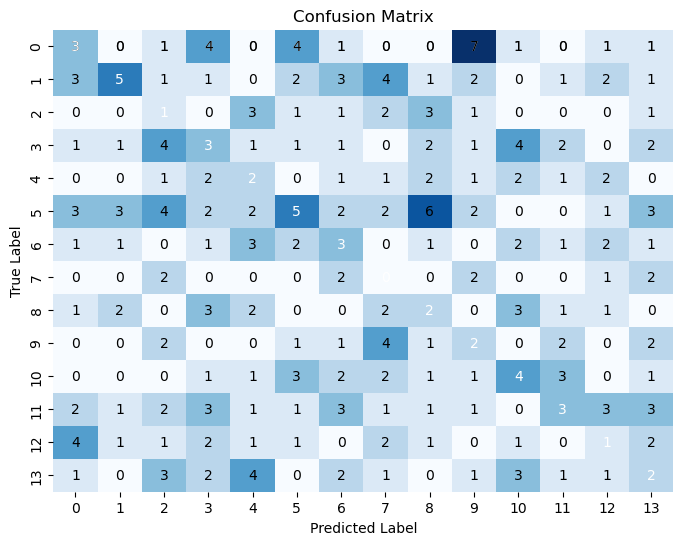

Classification Report:
               precision    recall  f1-score   support

           0       0.13      0.16      0.14        19
           1       0.19      0.36      0.25        14
           2       0.08      0.05      0.06        22
           3       0.13      0.12      0.13        24
           4       0.13      0.10      0.11        20
           5       0.14      0.24      0.18        21
           6       0.17      0.14      0.15        22
           7       0.00      0.00      0.00        21
           8       0.12      0.10      0.11        21
           9       0.13      0.10      0.11        21
          10       0.21      0.20      0.21        20
          11       0.12      0.20      0.15        15
          12       0.06      0.07      0.06        15
          13       0.10      0.10      0.10        21

    accuracy                           0.13       276
   macro avg       0.12      0.14      0.12       276
weighted avg       0.12      0.13      0.12       276



In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

class_list = set(y_test)

# Print confusion matrix
conf_matrix = confusion_matrix(y_pred, y_test)
# print("Confusion Matrix:\n", conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_list, yticklabels=class_list)

for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix[0])):
        if i == j:
            plt.text(j + 0.5, i + 0.5, str(conf_matrix[i, j]), ha='center', va='center', color='white')
        else:
            plt.text(j + 0.5, i + 0.5, str(conf_matrix[i, j]), ha='center', va='center', color='black')
            
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

In [55]:
np.savetxt('test_predictions.csv', np.hstack((y_test.reshape(-1, 1), y_pred.reshape(-1,1))), delimiter=',', fmt='%d')
np.savetxt('actual labels.csv', y_test.reshape(-1,1), delimiter=',', fmt='%d')

In [56]:
# Display the mapping between class names and encoded numbers
class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("\nClass Mapping:")
print(class_mapping)


Class Mapping:
{'bacterial_leaf_blight': 0, 'bacterial_leaf_streak': 1, 'bakanae': 2, 'brown_spot': 3, 'grassy_stunt_virus': 4, 'healthy_rice_plant': 5, 'narrow_brown_spot': 6, 'ragged_stunt_virus': 7, 'rice_blast': 8, 'rice_false_smut': 9, 'sheath_blight': 10, 'sheath_rot': 11, 'stem_rot': 12, 'tungro_virus': 13}
